In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import os

import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False ## 마이너스 부호 깨짐 방지

pd.set_option('display.max_columns', None)                       # 출력할 열의 최대개수
pd.set_option('display.max_colwidth', None)                      # 출력할 열의 너비
pd.set_option('display.unicode.east_asian_width', True) 

In [2]:
import psycopg2
import pandas.io.sql as sqlio
import math

# Redshift connection 함수
def get_Redshift_connection(autocommit):
    host={호스트명}
    redshift_user = {사용자명}
    redshift_pass = {비밀번호}
    port = 5439
    dbname = "airbnb"
    conn = psycopg2.connect("dbname={dbname} user={user} host={host} password={password} port={port}".format(
        dbname=dbname,
        user=redshift_user,
        password=redshift_pass,
        host=host,
        port=port
    ))
    conn.set_session(autocommit=autocommit)
    return conn

In [5]:
## Redshift 연결
conn = get_Redshift_connection(True)
cur = conn.cursor()

### 컬럼 설명
### train_users_2.csv
- id : 사용자 아이디
- date_account_created: 계정 생성 날짜
- timestamp_first_active: 첫 번째 활동의 타임스탬프입니다. 사용자가 가입하기 전에 검색할 수 있으므로 date_account_created 또는 date_first_booking보다 이전일 수 있습니다.
- date_first_booking: 첫 예약 날짜
- 성별
- 나이
- signup_method - 가입_방법
- signup_flow: 사용자가 가입하기 위해 온 페이지
- language: 국제 언어 기본 설정
- affili_channel: 유료 마케팅의 종류
- affiliate_provider: 마케팅이 이루어지는 곳. 구글, 크레이그리스트, 기타
- first_affiliate_tracked: 가입하기 전에 사용자가 처음으로 상호작용한 마케팅은 무엇입니까?
- signup_app - 가입_앱
- first_device_type - 첫 번째_장치_유형
- first_browser - 첫 번째_브라우저
- country_destination: 예측할 대상 변수입니다.
### session.csv - 사용자에 대한 웹 세션 로그
- user_id: users 테이블의 'id' 컬럼과 조인됩니다.
- action - 행동 
- action_type
- action_detail - 액션_디테일
- device_type - 기기 종류
- secs_elapsed - 초_경과 
#### country.csv - 이 데이터세트의 목적지 국가와 해당 위치에 대한 요약 통계
#### age_gender_bkts.csv - 사용자의 연령대, 성별, 목적지 국가에 대한 요약 통계
#### Sample_submission.csv - 예측 제출을 위한 올바른 형식

In [22]:
## sessions
sql = """SELECT * FROM raw_data.sessions"""
sessions = sqlio.read_sql_query(sql, conn)
sessions

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [ ]:
## 세션 데이터 정렬
sessions.sort_values(by='idx', inplace=True)

sessions.reset_index(drop=True, inplace=True)
sessions.drop(columns=['idx'], inplace=True)

In [23]:
sessions['action'].replace('-unknown-', 'unknown', inplace=True)
sessions['action_type'].replace('-unknown-', 'unknown', inplace=True)
sessions['action_detail'].replace('-unknown-', 'unknown', inplace=True)
sessions['device_type'].replace('-unknown-', 'unknown', inplace=True)

In [24]:
sessions['action'].fillna('error', inplace=True)
sessions['action_type'].fillna('unknown', inplace=True)
sessions['action_detail'].fillna('unknown', inplace=True)

### secs_elapsed 정렬

In [25]:
# 한 칸씩 위로 당겨오기
sessions['secs_elapsed'] = sessions['secs_elapsed'].shift(-1)

# 유저별 마지막 elapsed time은 측정되지 않았으므로 nan
last_order = sessions.groupby('user_id').tail(1).index
sessions.loc[last_order, 'secs_elapsed'] = np.NaN

In [26]:
sessions['user_flow'] = sessions['action'].astype('str') + '+' + sessions['action_type'].astype('str') + '+' + sessions['action_detail'].astype('str')

In [27]:
## train_users_2
sql = """SELECT * FROM raw_data.train_users_2"""
train = sqlio.read_sql_query(sql, conn)
train.rename(columns={'id':'user_id'},inplace=True)
train.head()

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


### timestamp_first_active ->  datetime 타입 변환

In [28]:
train['timestamp_first_active'] = pd.to_datetime(train['timestamp_first_active'], format = '%Y%m%d%H%M%S').dt.strftime('%Y-%m-%d')
train['timestamp_first_active'] = pd.to_datetime(train['timestamp_first_active'])
train['date_account_created'] = pd.to_datetime(train['date_account_created'])
train['date_first_booking'] = pd.to_datetime(train['date_first_booking'], errors='coerce')

In [29]:
train['gender'].replace('-unknown-', 'unknown', inplace=True)
train['first_browser'].replace('-unknown-', 'unknown', inplace=True)

train['first_affiliate_tracked'].fillna('untracked', inplace=True)

In [30]:
train.isnull().sum()

user_id                         0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked         0
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

### Train_Session 병합

In [31]:
df = pd.merge(sessions, train, on='user_id', how='inner')
df

,user_id,action,action_type,action_detail,device_type,secs_elapsed,user_flow,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,d1mm9tcy42,lookup,unknown,unknown,Windows Desktop,67753.0,lookup+unknown+unknown,2014-01-01,2014-01-01,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,301.0,search_results+click+view_search_results,2014-01-01,2014-01-01,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other
2,d1mm9tcy42,lookup,unknown,unknown,Windows Desktop,22141.0,lookup+unknown+unknown,2014-01-01,2014-01-01,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,435.0,search_results+click+view_search_results,2014-01-01,2014-01-01,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other
4,d1mm9tcy42,lookup,unknown,unknown,Windows Desktop,7703.0,lookup+unknown+unknown,2014-01-01,2014-01-01,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5537952,nw9fwlyb5f,index,data,reservations,iPhone,286.0,index+data+reservations,2014-06-30,2014-06-30,NaT,unknown,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,unknown,NDF
5537953,nw9fwlyb5f,unavailabilities,data,unavailable_dates,iPhone,830.0,unavailabilities+data+unavailable_dates,2014-06-30,2014-06-30,NaT,unknown,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,unknown,NDF
5537954,nw9fwlyb5f,notifications,submit,notifications,iPhone,101961.0,notifications+submit+notifications,2014-06-30,2014-06-30,NaT,unknown,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,unknown,NDF
5537955,nw9fwlyb5f,search,click,view_search_results,iPhone,10863.0,search+click+view_search_results,2014-06-30,2014-06-30,NaT,unknown,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,unknown,NDF


# 예약 (1)  vs 비예약 (0) 구분

In [32]:
df['binary_target'] = df['country_destination'].replace({'NDF': 0}, inplace=False)
df.loc[df['binary_target'] != 0, 'binary_target'] = 1

# 가입하지 않고 예약한 자 확인
- 로그 기록된 인원은 예약을 먼저하고 가입한 인원이 존재하지 않는다. 따라서 세션 데이터 유저는 가입 후 행동이 기록된다. 

In [33]:
df['booking_creation_delay'] = df['date_first_booking'] - df['date_account_created']

In [34]:
df[df['booking_creation_delay'] < pd.Timedelta(0)]

,user_id,action,action_type,action_detail,device_type,secs_elapsed,user_flow,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,binary_target,booking_creation_delay


## 사용자 데이터와 세션 데이터를 병합할 때 정보 손실 확인
- 예약 vs 비예약으로 손실 시각화

In [35]:
# 원본 train 비율
new_train = train.copy()

new_train['binary_target'] = new_train['country_destination'].replace({'NDF': 0}, inplace=False)
new_train.loc[new_train['binary_target'] != 0, 'binary_target'] = 1

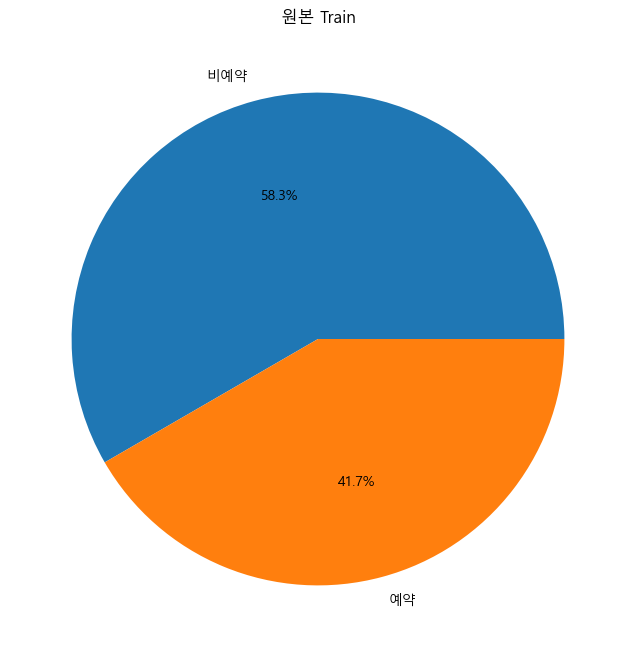

In [36]:
counts = new_train['binary_target'].value_counts(normalize=True).values
labels = ['비예약', '예약']
plt.figure(figsize=(8, 8))

plt.pie(counts, labels=labels, autopct='%.1f%%')
plt.title("원본 Train")
plt.show()

In [37]:
# 분석을 진행할 비율
mask = new_train['user_id'].isin(df['user_id'])

## session에 포함된 user로 구성 (중복 x)
new_df = new_train[mask]
new_df.reset_index(drop=True, inplace=True)

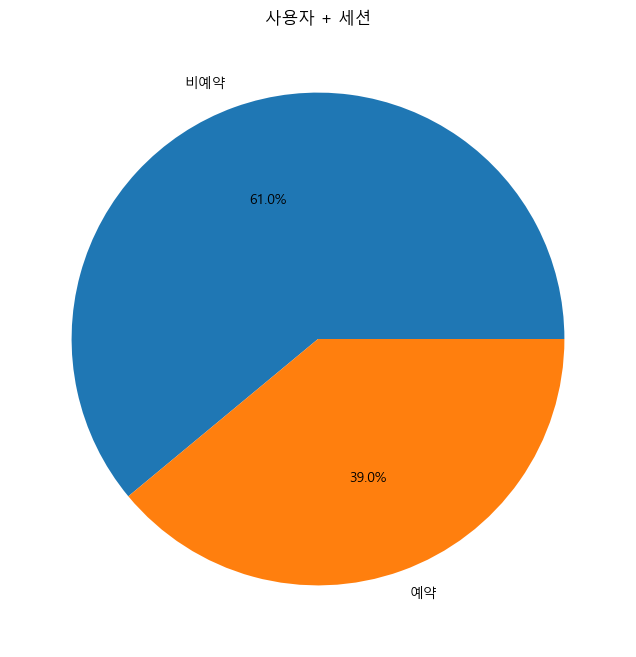

In [38]:
counts = new_df['binary_target'].value_counts(normalize=True).values
labels = ['비예약', '예약']

plt.figure(figsize=(8, 8))

plt.pie(counts, labels=labels, autopct='%.1f%%')
plt.title("사용자 + 세션")
plt.show()

## 범주형 변수 시각화
- 예약 vs 비예약

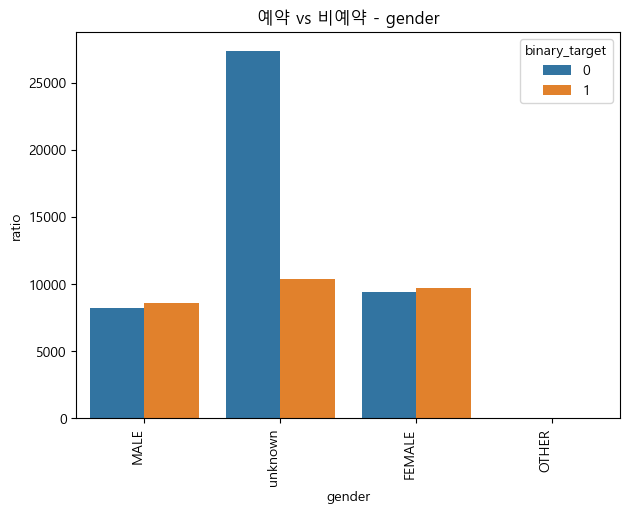

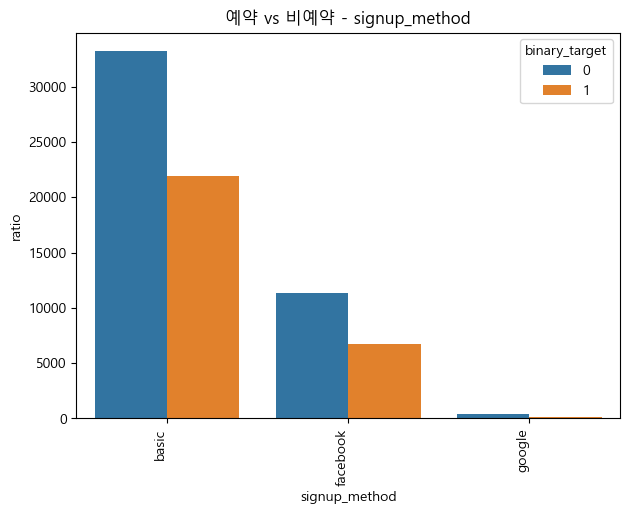

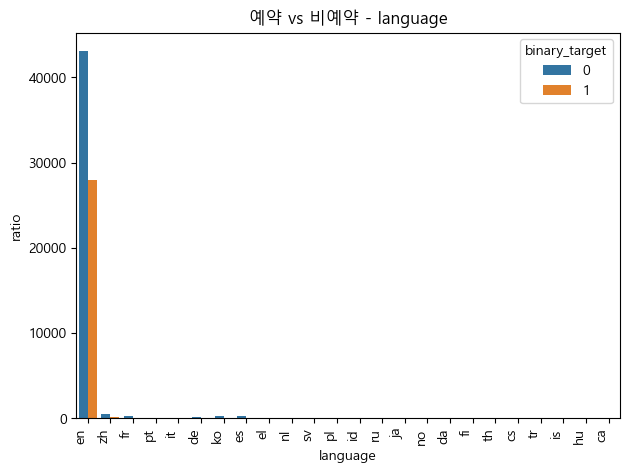

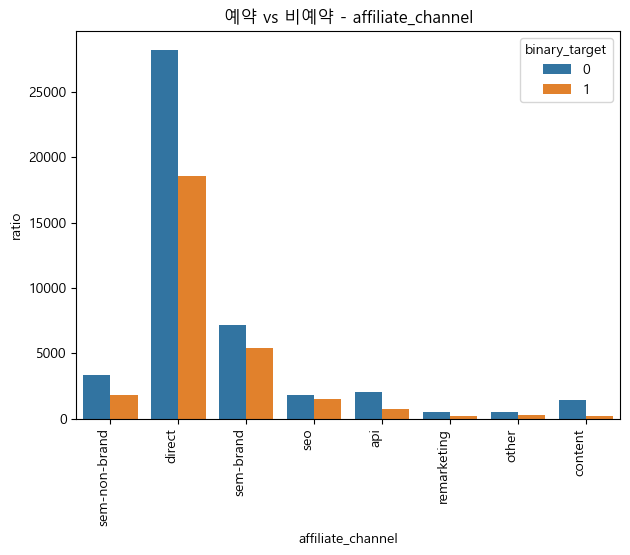

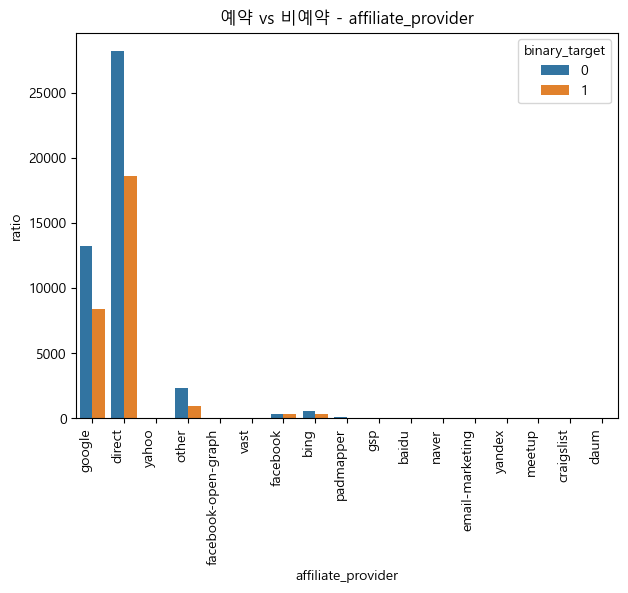

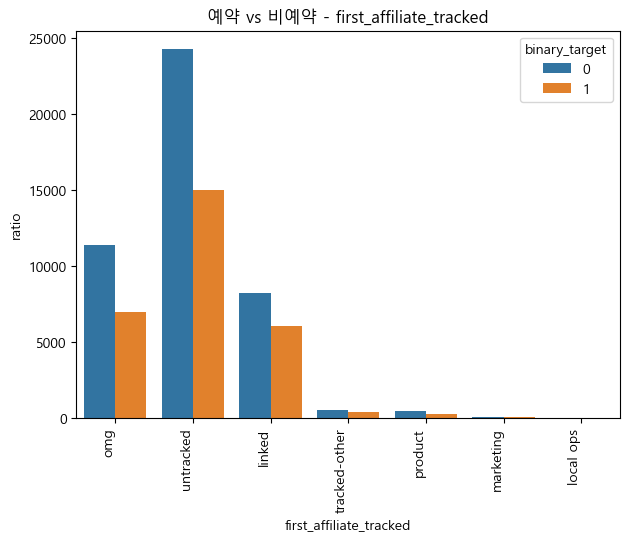

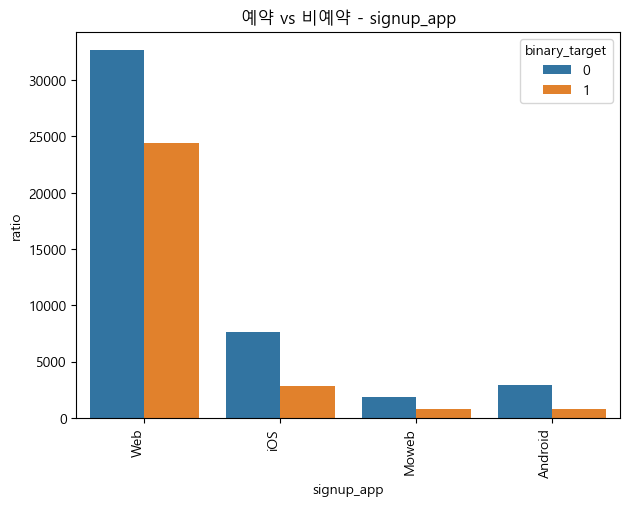

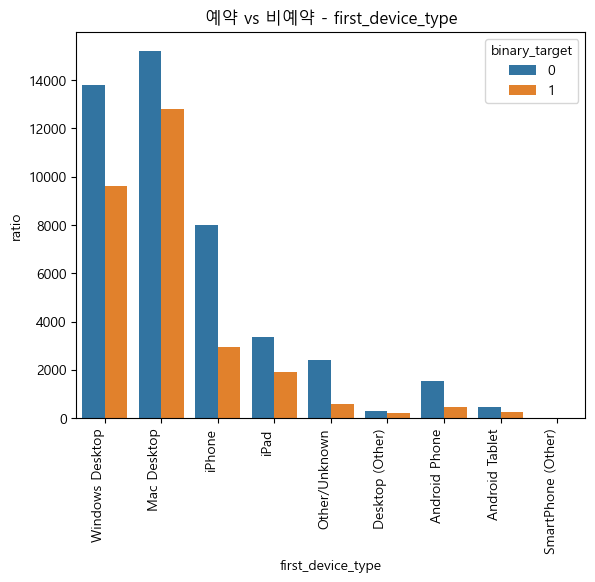

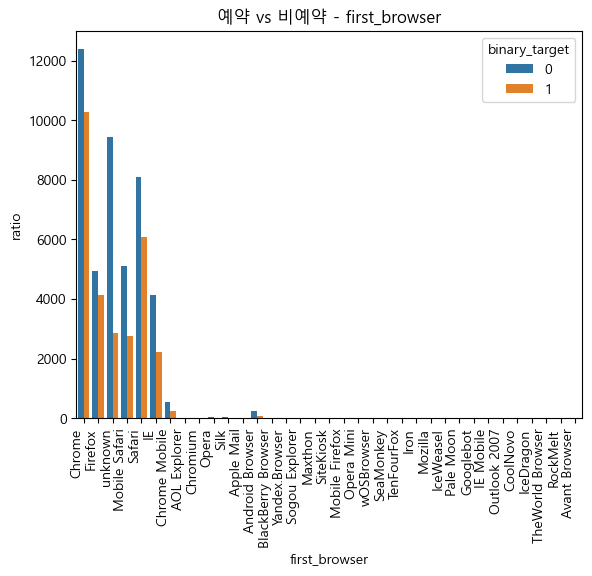

In [39]:
object_cols = new_df.select_dtypes('object').columns[1:-2]

for col in object_cols:
    sns.countplot(data = new_df, x=col, hue='binary_target')

    plt.tight_layout()
    plt.title(f'예약 vs 비예약 - {col}')
    plt.ylabel('ratio')
    plt.tight_layout()
    plt.xticks(rotation=90, ha='right')
    plt.show()

### 가설 1. 첫 여행지는 US로 많이 갔을 것이다. (시작지가 US이기 때문)
- 나도 첫 여행은 우리나라에서 시작
- 여행이라는 것을 서울에서 강릉을 가는 것을 생각한다면 굳이 비행기를 타고 다른 나라를 가는 것보다 많다고 생각함

### 결론
- 예약 그룹은 US(시작지)를 첫 여행지로 시작했다.

### 마케팅 전략
- 첫 가입 고객에게 고객의 국가를 기준으로 인기있는 숙박(호스트)를 추천 위시리스트로 알려준다.

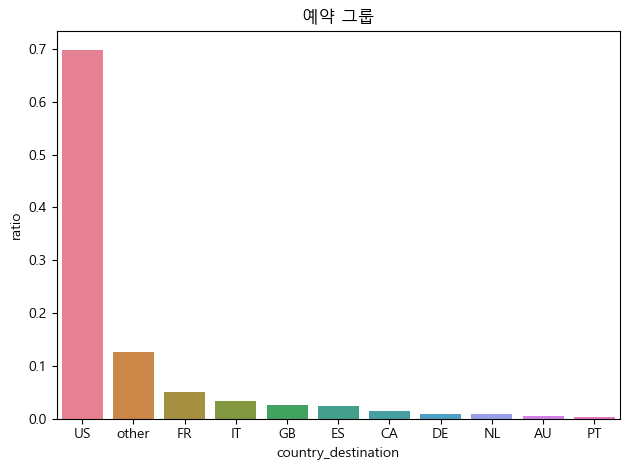

In [40]:
counts = new_df.loc[new_df['binary_target']==1,'country_destination'].value_counts(normalize=True).values
indx = new_df.loc[new_df['binary_target']==1,'country_destination'].value_counts(normalize=True).index

sns.barplot(x=indx, y=counts, hue=indx)

plt.title('예약 그룹')
plt.ylabel('ratio')
plt.tight_layout()
plt.show()

### 가설 2. 고객의 사용 언어와 같은 언어를 쓰는 나라로 갔을 것이다.

In [23]:
## 출발지와 목적지간의 거리 목적지의 언어, 언어 유사도 데이터를 합치기 위해서 데이터 전처리 과정 진행 
countries = pd.read_csv('countries.csv')

## destination_language에 띄어쓰기로 저장되어 수정
countries.columns = ['country_destination',
 'lat_destination',
 'lng_destination',
 'distance_km',
 'destination_km2',
 'destination_language',
 'language_levenshtein_distance']

### 필요하다고 생각되는 속성을 가지고 왔다. 
## US부터 거리, 도착지 언어, 언어 유사도
new_countries = countries[['country_destination', 'distance_km', 'destination_language', 'language_levenshtein_distance']].copy()
new_countries

,country_destination,distance_km,destination_language,language_levenshtein_distance
0,AU,15297.7440,eng,0.00
1,CA,2828.1333,eng,0.00
2,DE,7879.5680,deu,72.61
3,ES,7730.7240,spa,92.25
4,FR,7682.9450,fra,92.06
5,GB,6883.6590,eng,0.00
6,IT,8636.6310,ita,89.40
7,NL,7524.3203,nld,63.22
8,PT,7355.2534,por,95.45
9,US,0.0000,eng,0.00


In [24]:
## train에 존재하는 값을 임의로 생성 (NDF는 예약하지 않았기 때문에 알 수가 없음.)
data = {
    'country_destination': ['NDF', 'other'],
    'distance_km': [np.nan, np.nan],
    'destination_language': [np.nan, np.nan],
    'language_levenshtein_distance': [np.nan, np.nan]
}

make_countries = pd.DataFrame(data)
make_countries

,country_destination,distance_km,destination_language,language_levenshtein_distance
0,NDF,NaN,NaN,NaN
1,other,NaN,NaN,NaN


In [25]:
countries = pd.concat([new_countries, make_countries], ignore_index = True)
countries

,country_destination,distance_km,destination_language,language_levenshtein_distance
0,AU,15297.7440,eng,0.00
1,CA,2828.1333,eng,0.00
2,DE,7879.5680,deu,72.61
3,ES,7730.7240,spa,92.25
4,FR,7682.9450,fra,92.06
5,GB,6883.6590,eng,0.00
6,IT,8636.6310,ita,89.40
7,NL,7524.3203,nld,63.22
8,PT,7355.2534,por,95.45
9,US,0.0000,eng,0.00


In [26]:
## 기존 df에 데이터 병합
new_df = pd.merge(new_df, countries, on='country_destination')

In [27]:
# 예약자 그룹과 비예약자 그룹 분할
reserved_group = new_df[new_df['binary_target'] == 1]
not_reserved_group = new_df[new_df['binary_target'] == 0]

In [28]:
cross_tab = pd.crosstab(reserved_group['destination_language'], reserved_group['language'])
cross_tab

language,cs,da,de,el,en,es,fi,fr,hu,is,it,ja,ko,nl,no,pl,pt,ru,sv,th,tr,zh
destination_language,,,,,,,,,,,,,,,,,,,,,,
deu,0,0,8,0,237,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
eng,2,2,49,2,20910,48,1,66,2,1,11,27,71,2,1,0,11,22,9,2,1,178
fra,0,0,4,0,1383,5,1,22,0,0,2,0,9,1,0,0,0,1,0,0,0,7
ita,0,0,4,0,947,3,0,4,0,0,9,0,7,0,0,0,0,3,0,0,0,2
nld,0,0,0,0,242,1,0,1,0,0,0,0,0,2,0,0,0,0,1,0,0,0
por,0,0,1,0,79,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0
spa,0,0,2,1,682,6,0,5,0,0,3,1,0,0,0,2,1,3,0,0,0,1


In [29]:
destination_language_ratio = cross_tab.div(cross_tab.sum(axis=0), axis=1)
destination_language_ratio

language,cs,da,de,el,en,es,fi,fr,hu,is,it,ja,ko,nl,no,pl,pt,ru,sv,th,tr,zh
destination_language,,,,,,,,,,,,,,,,,,,,,,
deu,0.0,0.0,0.117647,0.000000,0.009681,0.000000,0.0,0.009901,0.0,0.0,0.038462,0.000000,0.000000,0.166667,0.0,0.000000,0.000000,0.033333,0.0,0.0,0.0,0.005291
eng,1.0,1.0,0.720588,0.666667,0.854167,0.761905,0.5,0.653465,1.0,1.0,0.423077,0.964286,0.816092,0.333333,1.0,0.000000,0.916667,0.733333,0.9,1.0,1.0,0.941799
fra,0.0,0.0,0.058824,0.000000,0.056495,0.079365,0.5,0.217822,0.0,0.0,0.076923,0.000000,0.103448,0.166667,0.0,0.000000,0.000000,0.033333,0.0,0.0,0.0,0.037037
ita,0.0,0.0,0.058824,0.000000,0.038685,0.047619,0.0,0.039604,0.0,0.0,0.346154,0.000000,0.080460,0.000000,0.0,0.000000,0.000000,0.100000,0.0,0.0,0.0,0.010582
nld,0.0,0.0,0.000000,0.000000,0.009886,0.015873,0.0,0.009901,0.0,0.0,0.000000,0.000000,0.000000,0.333333,0.0,0.000000,0.000000,0.000000,0.1,0.0,0.0,0.000000
por,0.0,0.0,0.014706,0.000000,0.003227,0.000000,0.0,0.019802,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.333333,0.000000,0.000000,0.0,0.0,0.0,0.000000
spa,0.0,0.0,0.029412,0.333333,0.027859,0.095238,0.0,0.049505,0.0,0.0,0.115385,0.035714,0.000000,0.000000,0.0,0.666667,0.083333,0.100000,0.0,0.0,0.0,0.005291


### 결론
- pl: 폴란드어를 사용하는 유저는 spa 나라로 많이 간 것을 알 수 있다.
- 대부분 목적지 국가의 언어가 영어권인 나라를 많이 갔다.

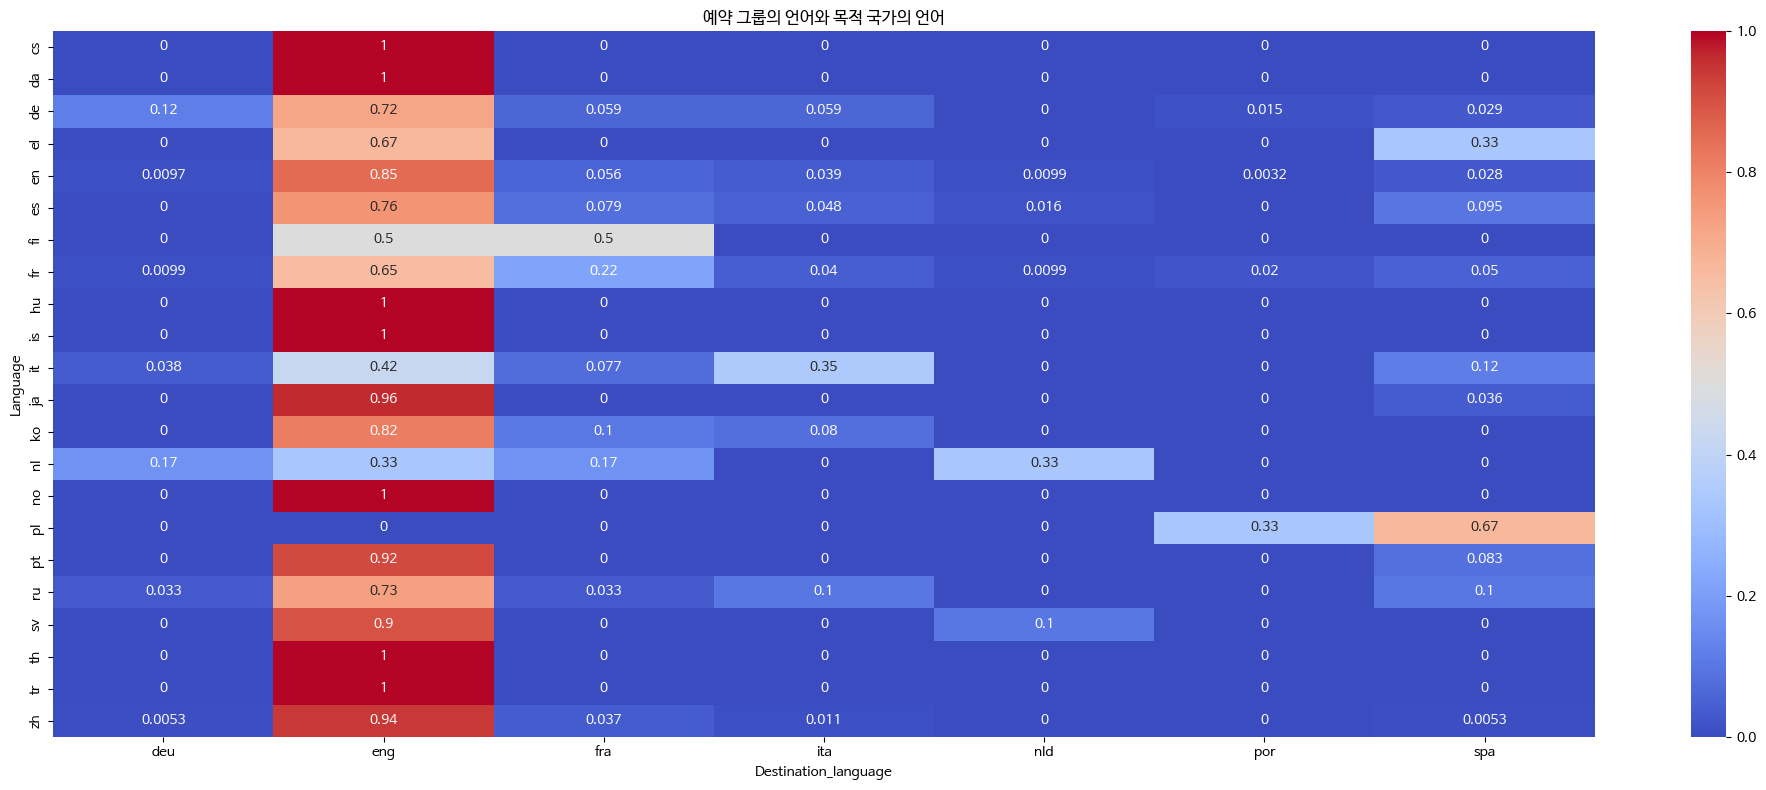

In [30]:
plt.figure(figsize=(20, 8))

sns.heatmap(destination_language_ratio.T, cmap='coolwarm', annot=True)

plt.title('예약 그룹의 언어와 목적 국가의 언어')
plt.ylabel('Language')
plt.xlabel('Destination_language')
plt.tight_layout()
plt.show()

### 가입 후 월별 국가 선호도 추이

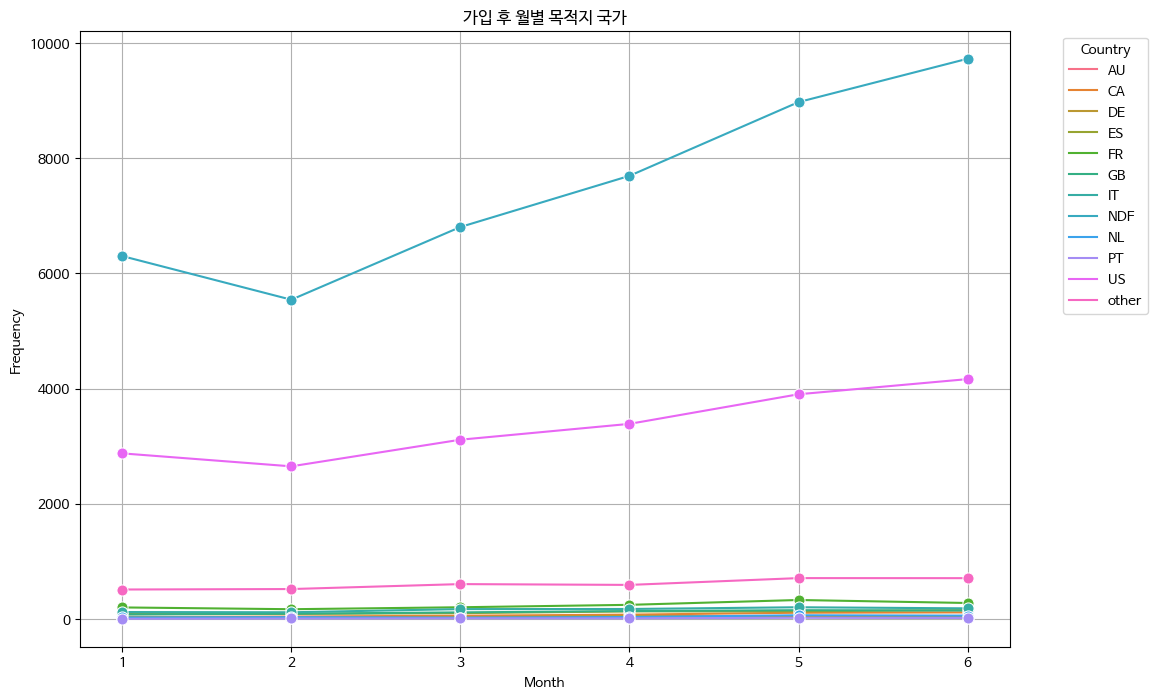

In [31]:
###### 
month = pd.to_datetime(new_df['date_account_created']).dt.month
country_destination = new_df['country_destination']

# DataFrame 생성
data = pd.DataFrame({'Month': month, 'Country': country_destination})

# 목적 국가와 월별 빈도 계산
country_month_counts = data.groupby(['Country', 'Month']).size().reset_index(name='Frequency')

# 월별 그래프 그리기
plt.figure(figsize=(12, 8))
sns.lineplot(data=country_month_counts, x='Month', y='Frequency', hue='Country', marker='o', markersize=8)
plt.title('가입 후 월별 목적지 국가')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(range(1, 7))  # 1월부터 6월
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

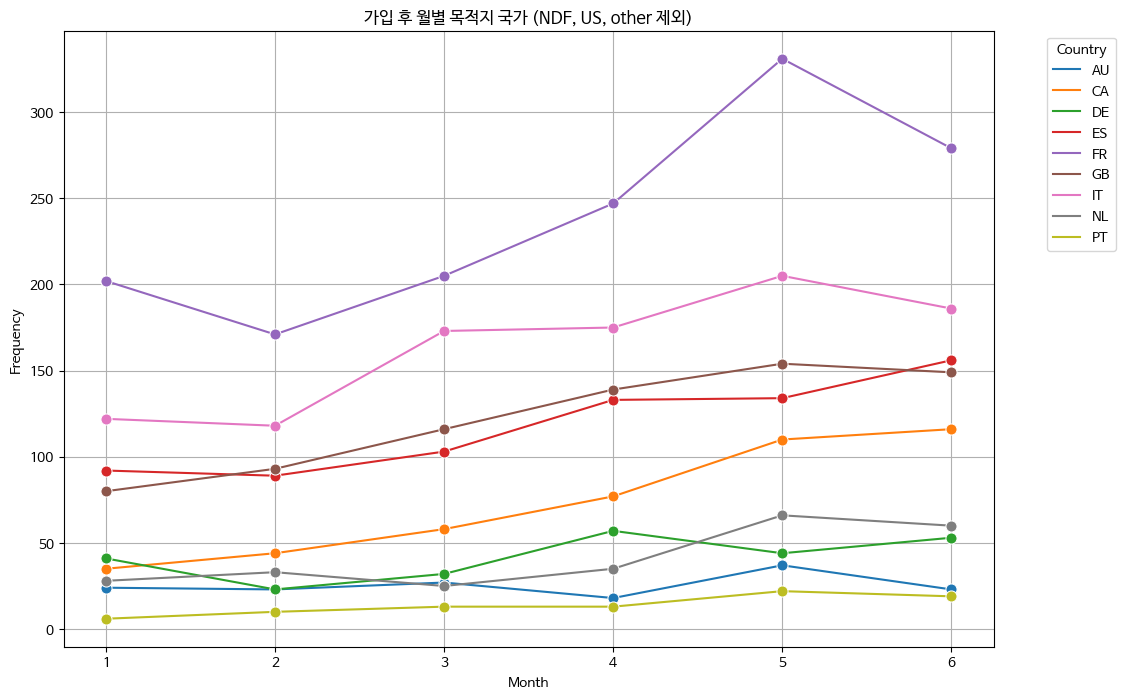

In [32]:
###### 
month = pd.to_datetime(new_df['date_account_created']).dt.month
country_destination = new_df['country_destination']

# DataFrame 생성
data = pd.DataFrame({'Month': month, 'Country': country_destination})

# NDF와 US 국가 제외
data = data[~data['Country'].isin(['NDF', 'US', 'other'])]

# 목적 국가와 월별 빈도 계산
country_month_counts = data.groupby(['Country', 'Month']).size().reset_index(name='Frequency')

# 월별 그래프 그리기
plt.figure(figsize=(12, 8))
sns.lineplot(data=country_month_counts, x='Month', y='Frequency', hue='Country', marker='o', markersize=8)
plt.title('가입 후 월별 목적지 국가 (NDF, US, other 제외)')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(range(1, 7))  # 1월부터 6월
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

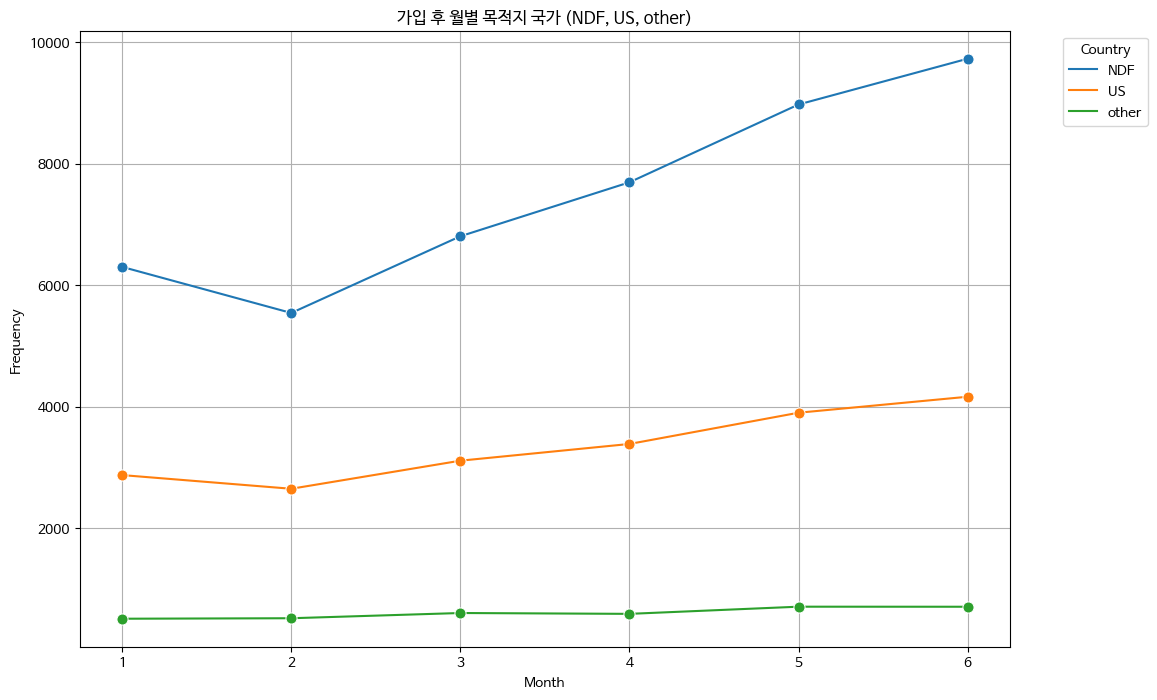

In [33]:
###### 
month = pd.to_datetime(new_df['date_account_created']).dt.month
country_destination = new_df['country_destination']

# DataFrame 생성
data = pd.DataFrame({'Month': month, 'Country': country_destination})

# NDF, US, other 국가
data = data[data['Country'].isin(['NDF', 'US', 'other'])]

# 목적 국가와 월별 빈도 계산
country_month_counts = data.groupby(['Country', 'Month']).size().reset_index(name='Frequency')

# 월별 그래프 그리기
plt.figure(figsize=(12, 8))
sns.lineplot(data=country_month_counts, x='Month', y='Frequency', hue='Country', marker='o', markersize=8)
plt.title('가입 후 월별 목적지 국가 (NDF, US, other)')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(range(1, 7))  # 1월부터 6월
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

## 군집화

In [34]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
le = LabelEncoder()
ss = StandardScaler()

In [40]:
ss_new_df = new_df.copy()

## 불필요한 데이터 및 정답 데이터는 제거
ss_new_df = ss_new_df.drop(columns=['user_id','age', 'date_account_created', 'timestamp_first_active', 'date_first_booking', 'country_destination', 'binary_target', 'distance_km','destination_language','language_levenshtein_distance' ])
ss_new_df['first_affiliate_tracked'].fillna("unknown",inplace=True)

cols = ss_new_df.select_dtypes(exclude='object').columns
ss_new_df[cols] = ss.fit_transform(ss_new_df[cols])

In [41]:
catColumnsPos = [ss_new_df.columns.get_loc(col) for col in list(ss_new_df.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(ss_new_df.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
Categorical columns position  : [0, 1, 3, 4, 5, 6, 7, 8, 9]


In [42]:
from kmodes.kprototypes import KPrototypes

dfMatrix = ss_new_df.to_numpy()

In [43]:
cost = []
for x in range(2,6):
    kprototype = KPrototypes(n_jobs = -1, n_clusters = x, init = 'Huang', random_state = random_seed)
    clusters = kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
    cost.append(kprototype.cost_)
    print('Cluster initiation: {}'.format(clusters))

Cluster initiation: [0 0 0 ... 0 0 0]
Cluster initiation: [1 1 0 ... 0 0 0]
Cluster initiation: [0 0 2 ... 2 2 2]
Cluster initiation: [2 0 0 ... 0 0 1]


In [44]:
df_cost = pd.DataFrame()
df_cost['clusters'] = range(2, 6)
df_cost['cost'] = cost

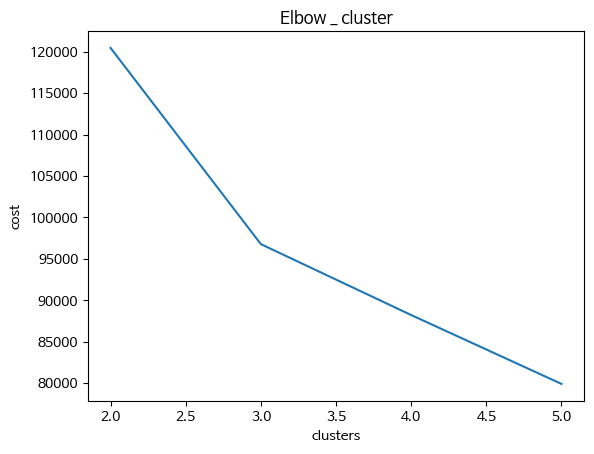

In [45]:
# elbow method 
sns.lineplot(x='clusters', y= 'cost', data=df_cost)
plt.title("Elbow _ cluster")
plt.show()

In [46]:
# Kmeans tuned
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = random_seed)
clusters = kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

In [50]:
ss_new_df['clusters'] = clusters
new_df['clusters'] = clusters

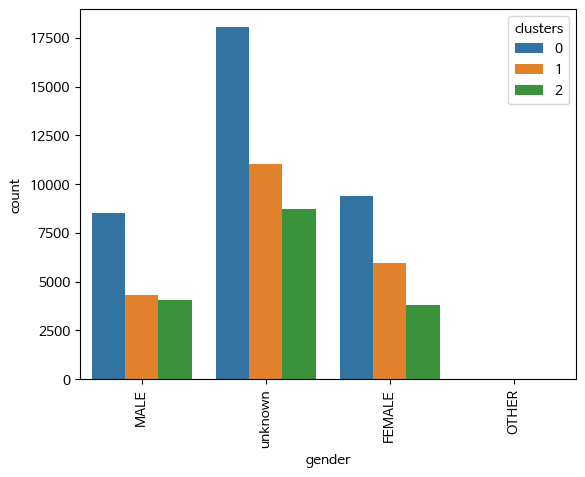

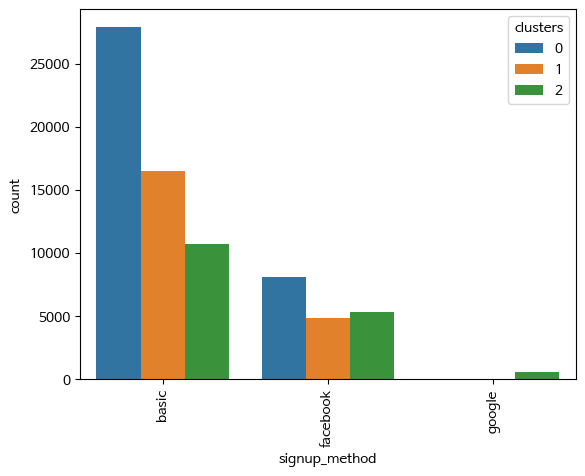

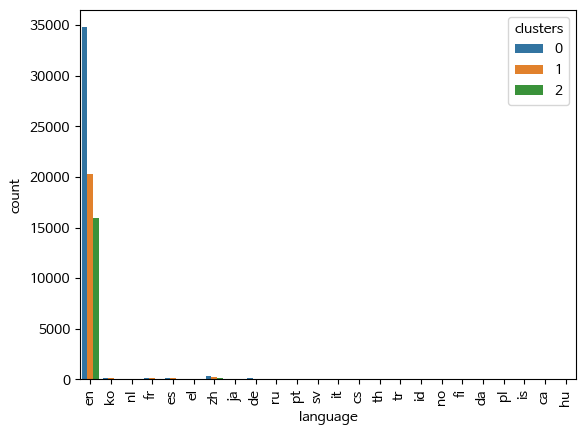

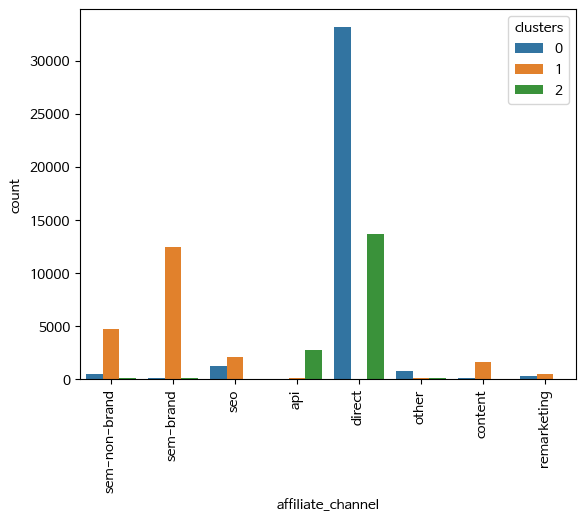

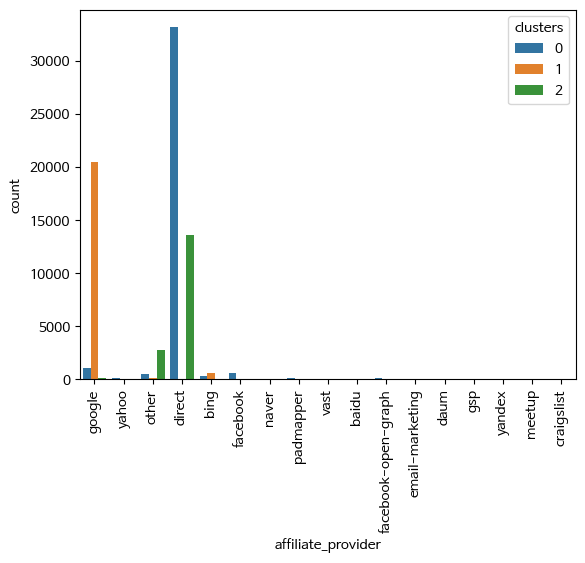

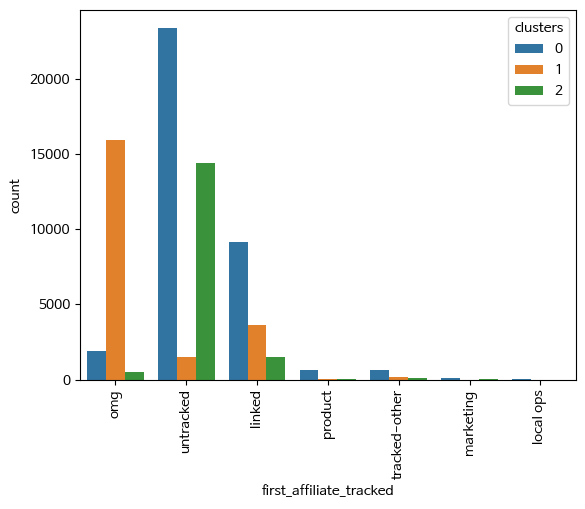

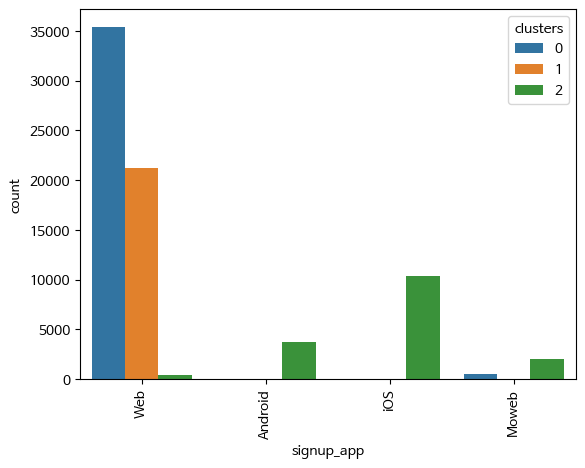

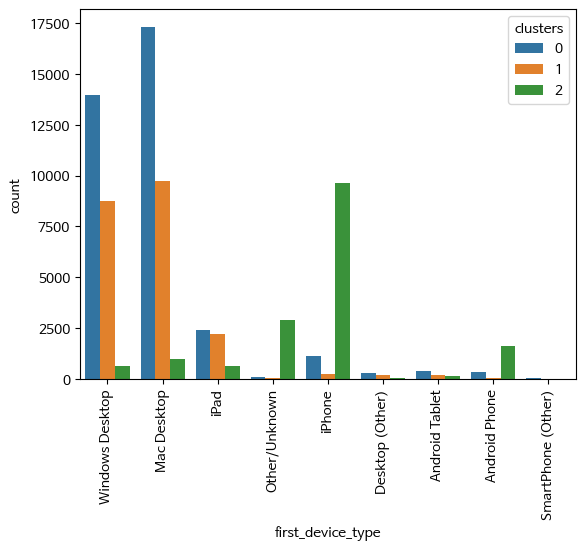

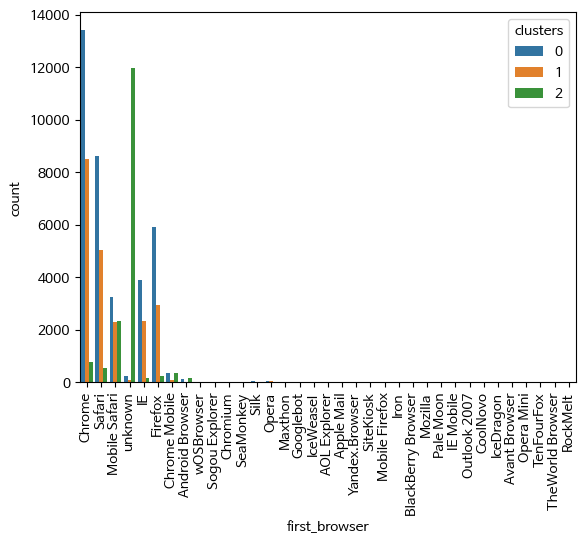

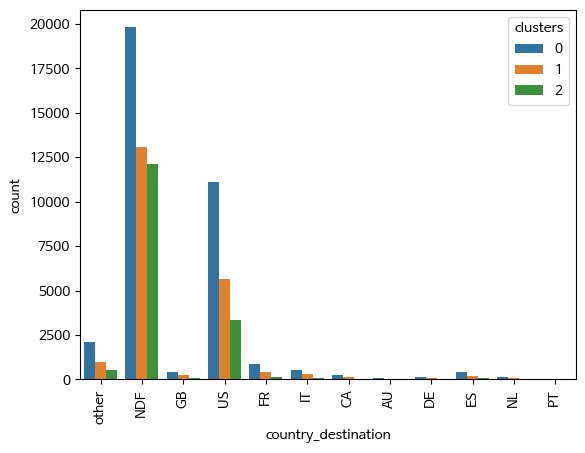

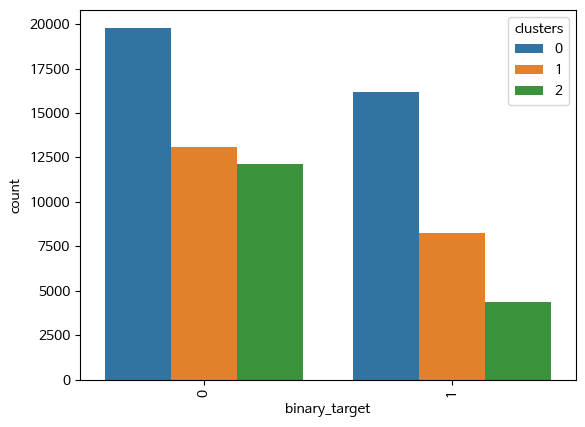

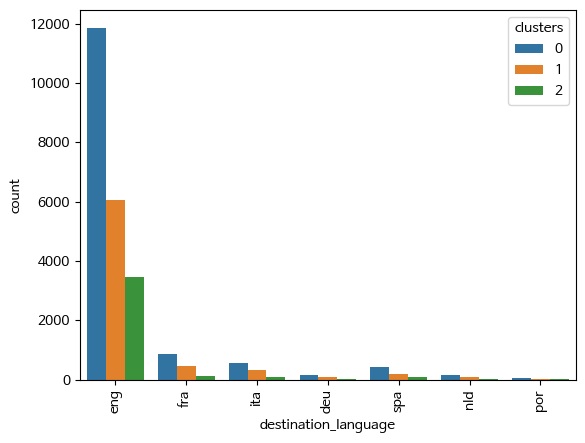

In [58]:
cols = new_df.select_dtypes('object').columns[1:]

for col in cols:
    sns.countplot(data=new_df, x=col, hue='clusters')
    plt.xticks(rotation=90) 
    plt.show()